In [ ]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras_tuner import Hyperband

warnings.filterwarnings('ignore')

<ipython-input-1-52dd6ae9218d>:16: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        tf.config.set_visible_devices(gpus[0], 'GPU')
        print("GPU is active!")
    except RuntimeError as e:
        print(e)

GPU is active!


In [ ]:
train_directory = "../b. Datasets/Covid 19 Dataset/Train"
test_directory = "../b. Datasets/Covid 19 Dataset/Test"

In [4]:
train_data_generator = ImageDataGenerator(
    rescale=1/255.0,
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    channel_shift_range=0.2,
    fill_mode='nearest'
)

test_data_generator = ImageDataGenerator(rescale=1/255.0)

In [5]:
train_generator = train_data_generator.flow_from_directory(
    train_directory,
    target_size=(200, 200),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_data_generator.flow_from_directory(
    test_directory,
    target_size=(200, 200),
    batch_size=32,
    class_mode='binary'
)

Found 207 images belonging to 2 classes.
Found 207 images belonging to 2 classes.


In [6]:
model = Sequential()

# Convolutional Neural Network starts
# Layer 1
model.add(Conv2D(64, (5, 5), input_shape=(200, 200, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 2
model.add(Conv2D(32, (5, 5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 3
model.add(Conv2D(16, (5, 5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten 
model.add(Flatten())

# Fully connected layers
# Layer 1
model.add(Dense(units=256, kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(rate=0.5))

# Layer 2
model.add(Dense(units=128, kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(rate=0.5))

# Layer 3
model.add(Dense(units=64, kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(rate=0.5))

# Layer 4
model.add(Dense(units=1, kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Activation('sigmoid'))

In [7]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 200, 200, 64)        │           4,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 200, 200, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 200, 200, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 100, 100, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 100, 100, 32)        │          51,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 100, 100, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 100, 100, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 50, 50, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 50, 50, 16)          │          12,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 50, 50, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 50, 50, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 25, 25, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 10000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       2,560,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │              

 Total params: 2,672,629 (10.20 MB)

 Trainable params: 2,671,507 (10.19 MB)

 Non-trainable params: 1,122 (4.38 KB)

In [8]:
adam_optimiser = Adam(learning_rate=0.01, weight_decay=0.005)
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [9]:
early_stopping_callback = EarlyStopping(patience=10, 
                                        restore_best_weights=True)

model_checkpoint_callback = ModelCheckpoint("best_covid_classification_model.keras", 
                                            save_best_only=True)

In [10]:
history = model.fit(train_generator, 
                    epochs=5, 
                    validation_data=test_generator, 
                    callbacks=[early_stopping_callback, 
                               model_checkpoint_callback])

Epoch 1/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.4921 - loss: 8.3416 - val_accuracy: 0.4928 - val_loss: 8.2291
Epoch 2/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 172ms/step - accuracy: 0.4711 - loss: 8.2266 - val_accuracy: 0.4928 - val_loss: 8.9361
Epoch 3/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 183ms/step - accuracy: 0.5887 - loss: 7.9376 - val_accuracy: 0.4928 - val_loss: 9.3861
Epoch 4/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 179ms/step - accuracy: 0.5615 - loss: 7.5880 - val_accuracy: 0.4928 - val_loss: 8.5302
Epoch 5/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 217ms/step - accuracy: 0.5330 - loss: 7.2147 - val_accuracy: 0.5169 - val_loss: 7.1865


In [11]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"The test set accuracy is {test_accuracy} and the loss is {test_loss}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.5140 - loss: 7.1750
The test set accuracy is 0.5169082283973694 and the loss is 7.186524391174316


In [12]:
train_accuracy = history.history['accuracy']
train_loss = history.history['loss']

validation_accuracy = history.history['val_accuracy']
validation_loss = history.history['val_loss']

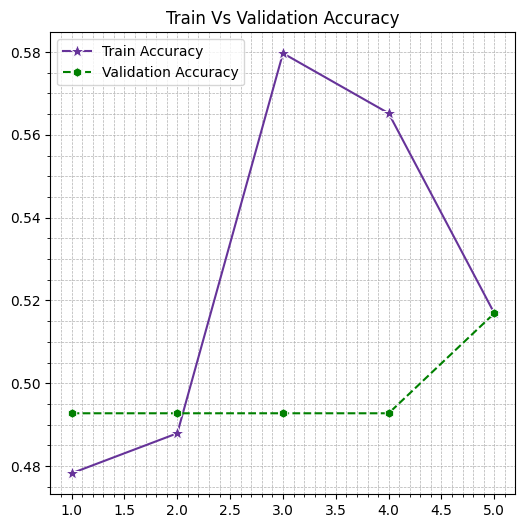

In [13]:
epochs = list(range(1, len(train_accuracy) + 1))
plt.figure(figsize=(6, 6))
sns.lineplot(x=epochs, y=train_accuracy, 
             color='rebeccapurple', 
             label='Train Accuracy', 
             marker="*", 
             markersize=10, 
             linestyle='-')
sns.lineplot(x=epochs, y=validation_accuracy, 
             color='green',
             label='Validation Accuracy', 
             marker="h", 
             markersize=7, 
             linestyle='--')
plt.title('Train Vs Validation Accuracy')
plt.minorticks_on()
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.legend(loc='best')
plt.show()

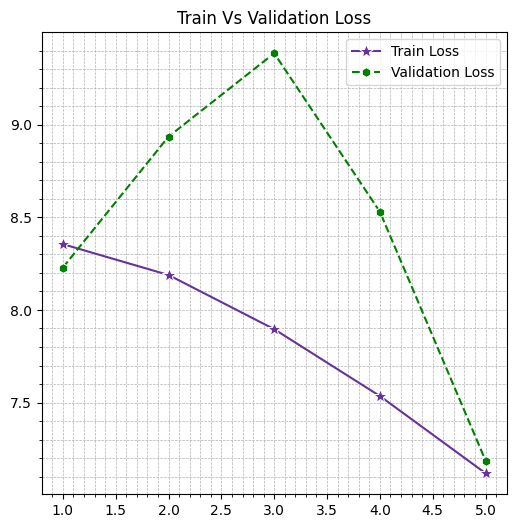

In [14]:
epochs = list(range(1, len(train_loss) + 1))
plt.figure(figsize=(6, 6))
sns.lineplot(x=epochs, y=train_loss, 
             color='rebeccapurple', 
             label='Train Loss', 
             marker="*", 
             markersize=10, 
             linestyle='-')
sns.lineplot(x=epochs, y=validation_loss, 
             color='green',
             label='Validation Loss', 
             marker="h", 
             markersize=7, 
             linestyle='--')
plt.title('Train Vs Validation Loss')
plt.minorticks_on()
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.legend(loc='best')
plt.show()

In [15]:
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 174ms/step


In [16]:
print(f'Max predicted class index: {np.max(predicted_classes)}')
print(f'Max true class index: {np.max(true_classes)}')
print(f'Number of class labels: {len(class_labels)}')

Max predicted class index: 0
Max true class index: 1
Number of class labels: 2


In [17]:
def plot_predictions(generator, predictions, true_classes, class_labels, number_of_images=5):
    images, _ = next(generator)
    
    plt.figure(figsize=(15, 15))
    
    for i in range(min(number_of_images, len(images))):
        plt.subplot(1, number_of_images, i+1)
        plt.imshow(images[i])
        try:
            true_label = class_labels[true_classes[i]]
            predicted_label = class_labels[predicted_classes[i]]
        except IndexError as ie:
            print("Index error encountered.", ie)
            continue
        plt.show()

In [18]:
def plot_predictions(generator, predictions, true_classes, class_labels, number_of_images=5):
    images, _ = next(generator)
    
    # Handle both 1D and 2D predictions
    predicted_classes = np.argmax(predictions, axis=1) if predictions.ndim > 1 else predictions

    plt.figure(figsize=(15, 5))

    for i in range(min(number_of_images, len(images))):
        plt.subplot(1, number_of_images, i + 1)
        plt.imshow(images[i], aspect='auto')  # Adjusts for varying sizes
        plt.axis("off")

        try:
            true_label = class_labels[true_classes[i]]
            predicted_label = class_labels[predicted_classes[i]]
            plt.title(f'True: {true_label}\nPred: {predicted_label}', fontsize=10)
        except IndexError as ie:
            print("Index error encountered.", ie)
            continue

    plt.tight_layout()
    plt.show()


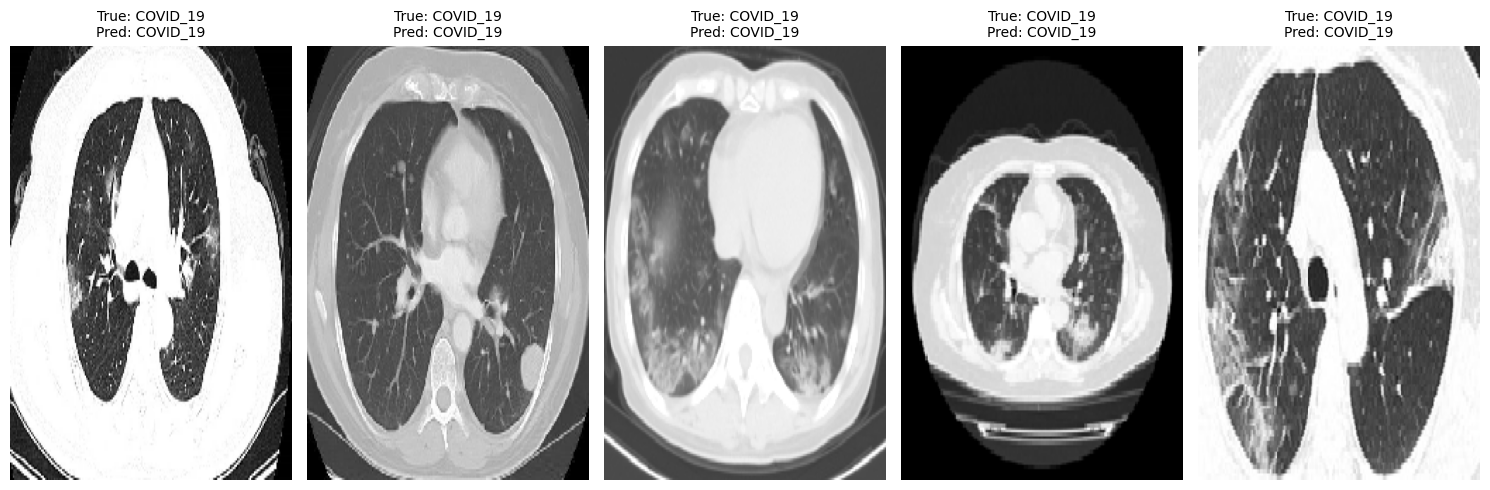

In [19]:
plot_predictions(test_generator, predicted_classes, true_classes, class_labels, 5)

In [20]:
def build_model(hp):
    model = Sequential()

    # Convolutional Neural Network starts
    # Layer 1
    model.add(Conv2D(64, (5, 5), input_shape=(200, 200, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Layer 2
    model.add(Conv2D(32, (5, 5), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Layer 3
    model.add(Conv2D(16, (5, 5), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flatten 
    model.add(Flatten())

    # Fully connected layers
    # Layer 1
    model.add(Dense(units=256, kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(rate=0.5))

    # Layer 2
    model.add(Dense(units=128, kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(rate=0.5))

    # Layer 3
    model.add(Dense(units=64, kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(rate=0.5))

    # Layer 4
    model.add(Dense(units=1, kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Activation('sigmoid'))
    
    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [21]:
tuner = Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=20,
    factor=3,
    directory='hyperparam_tuning',
    project_name='covid_classification'
)

stop_early = EarlyStopping(monitor='val_loss', patience=5)

tuner.search(train_generator, 
             epochs=20, 
             validation_data=test_generator, 
             callbacks=[stop_early])

Trial 3 Complete [00h 00m 27s]
val_accuracy: 0.49275362491607666

Best val_accuracy So Far: 0.5072463750839233
Total elapsed time: 00h 01m 19s


In [22]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)

In [23]:
early_stopping_callback = EarlyStopping(patience=10, 
                                        restore_best_weights=True)

model_checkpoint_callback = ModelCheckpoint("best_covid_classification_model.keras", 
                                            save_best_only=True)

In [24]:
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=30,
    callbacks=[early_stopping_callback, 
               model_checkpoint_callback]
)

Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.5399 - loss: 11.8937 - val_accuracy: 0.4928 - val_loss: 556.8561
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 208ms/step - accuracy: 0.5768 - loss: 16.7486 - val_accuracy: 0.4928 - val_loss: 382.7069
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 226ms/step - accuracy: 0.6375 - loss: 8.7515 - val_accuracy: 0.4928 - val_loss: 53.7749
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 205ms/step - accuracy: 0.5853 - loss: 4.5701 - val_accuracy: 0.4928 - val_loss: 20.6681
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 208ms/step - accuracy: 0.5709 - loss: 3.4131 - val_accuracy: 0.5169 - val_loss: 3.4025
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 221ms/step - accuracy: 0.4962 - loss: 2.6106 - val_accuracy: 0.6329 - val_loss: 2.1306
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 167ms/step - accuracy: 0.5733 - loss: 2.0667 - val_accuracy: 0.4928 - val_loss: 2.5301
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 208ms/step - accuracy: 0.5864 - loss: 1.6908 - val_accuracy: 0.5024 - val

In [25]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.6166 - loss: 1.4021
Test Accuracy: 0.6377


In [31]:
train_accuracy = history.history['accuracy']
train_loss = history.history['loss']

validation_accuracy = history.history['val_accuracy']
validation_loss = history.history['val_loss']

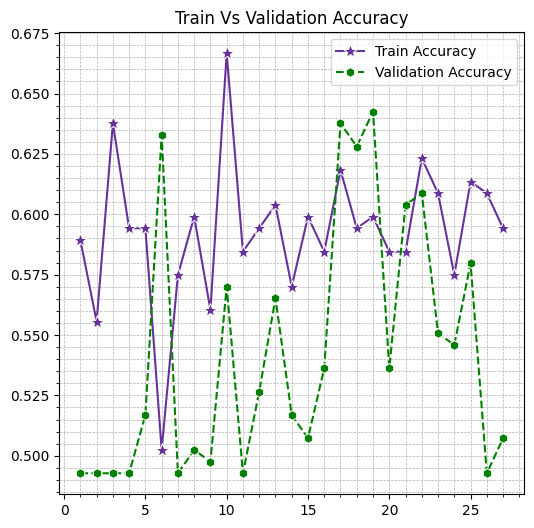

In [32]:
epochs = list(range(1, len(train_accuracy) + 1))
plt.figure(figsize=(6, 6))
sns.lineplot(x=epochs, y=train_accuracy, 
             color='rebeccapurple', 
             label='Train Accuracy', 
             marker="*", 
             markersize=10, 
             linestyle='-')
sns.lineplot(x=epochs, y=validation_accuracy, 
             color='green',
             label='Validation Accuracy', 
             marker="h", 
             markersize=7, 
             linestyle='--')
plt.title('Train Vs Validation Accuracy')
plt.minorticks_on()
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.legend(loc='best')
plt.show()

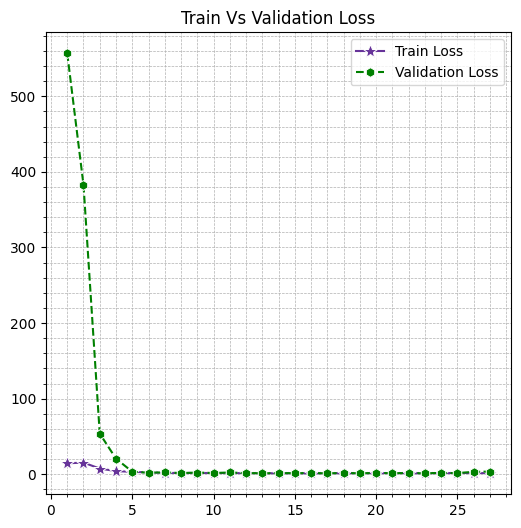

In [33]:
epochs = list(range(1, len(train_loss) + 1))
plt.figure(figsize=(6, 6))
sns.lineplot(x=epochs, y=train_loss, 
             color='rebeccapurple', 
             label='Train Loss', 
             marker="*", 
             markersize=10, 
             linestyle='-')
sns.lineplot(x=epochs, y=validation_loss, 
             color='green',
             label='Validation Loss', 
             marker="h", 
             markersize=7, 
             linestyle='--')
plt.title('Train Vs Validation Loss')
plt.minorticks_on()
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.legend(loc='best')
plt.show()

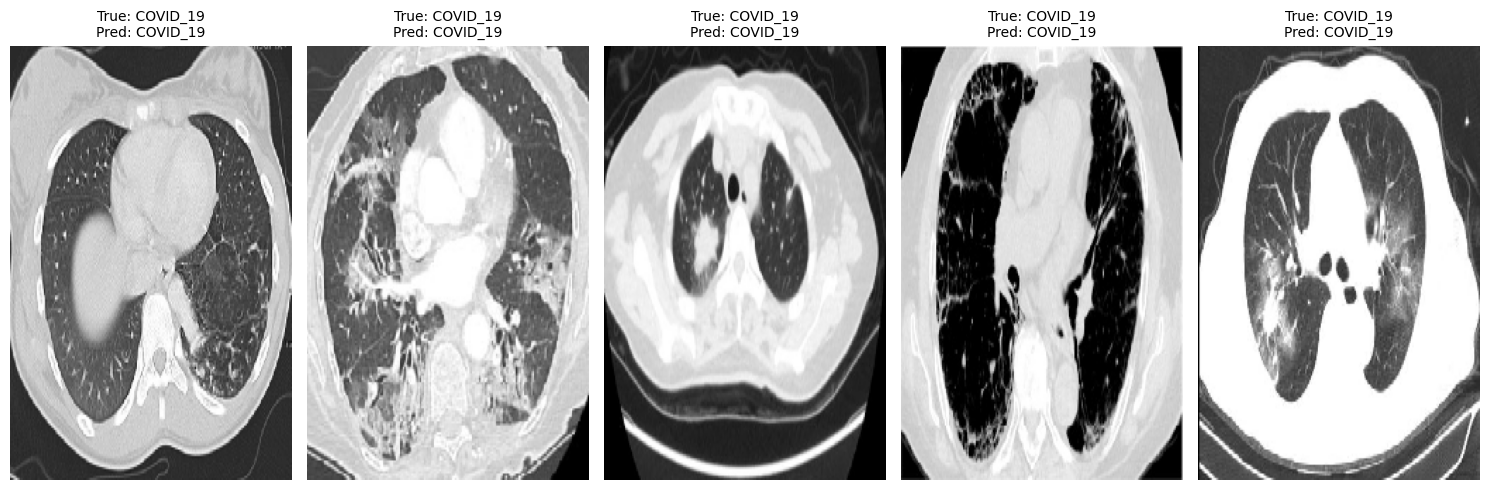

In [34]:
plot_predictions(test_generator, predicted_classes, true_classes, class_labels, 5)

In [43]:
prediction = model.predict(test_generator)
predictions = (prediction > 0.5).astype(int).ravel()
filenames = test_generator.filenames

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step


In [44]:
submission_df = pd.DataFrame({'Filename': filenames, 'Prediction': predictions})
submission_df.to_csv('predictions.csv', index=False)
print("CSV file saved successfully!")

CSV file saved successfully!


In [38]:
print("Final test accuracy", test_accuracy)

Final test accuracy 0.6376811861991882
